In [1]:
import pickle
import numpy as np
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files, make_directory, check_many
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from copy import copy


In [2]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(r, c, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, LAB, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx.T, cmap=cmap)
    else:
        iw = ax.imshow(mx.T, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation Layer")
        ax.set_xlabel("Simulation Layer")
        ax.set_xticks(np.arange(11).astype(int))
        ax.set_xticklabels(LAB)
        ax.set_yticks(np.arange(11).astype(int))
        ax.set_yticklabels(LAB)
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[0]):
        normed = mx[l,:] - np.min(mx[l,:])
        norm[l,:] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

    
def normalize(x):
    maxx, minx = max(x), min(x)
    max_minus_min = maxx - minx
    return np.array([(elt - minx) / max_minus_min for elt in x])


def bootstrap_func(data, n_boot=1000, prop=0.5, func="mean"):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        if func == "mean":
            results.append(data[boot_rows].mean(axis=0))
        elif func == "sem":
            results.append(data[boot_rows].std(axis=0) / np.sqrt(prop_rows))
    return np.array(results)

def bootstrap(data, n_boot=1000, prop=0.5):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        results.append(data[boot_rows])
    return np.array(results)

def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [3]:
n_layers = 11
snr_path = Path("/home/bonaiuto/laminar_baby/output/snr_simulations/")
snr_files = get_files(snr_path, "*.pickle")
coreg_path = Path("/home/bonaiuto/laminar_baby/output/coreg_err_simulations/")
coreg_files = get_files(coreg_path, "*.pickle")
snr_levels = [-50, -35, -20, -10, -5, 0, 5]
err_levels = [0, 0.5, 1, 2, 3, 4, 5]
vertices = np.unique([eval(f.stem.split("_")[1]) for f in snr_files])
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "S"
LAB[-1] = "D"

In [4]:
snr_levels[::-1]

[5, 0, -5, -10, -20, -35, -50]

In [19]:
### SNR ###
output_dir = Path("/home/bonaiuto/laminar_baby/figures/")

am_wins = len(snr_levels)
matrices_all = {i: [] for i in snr_levels}
peaks_all = {i: [] for i in snr_levels}
annots_bin = {i: [] for i in snr_levels}
shuffled_matrices_all = {i: [] for i in snr_levels}
shuffled_peaks_all = {i: [] for i in snr_levels}

for vx in vertices:
    vx_files = [i for i in snr_files if str(vx) in i.stem]
    
    mx_all = []
    for snr_ix, snr in enumerate(snr_levels):
        file_in = [i for i in vx_files if str(snr) == i.stem.split("_")[-1]][0]
        with open(file_in, "rb") as file:
            output = pickle.load(file)
        mx_all.append(norm_res(output["all_layerF"]))
    mx_max = np.array(mx_all).max()
    f, ax = plt.subplots(1, am_wins, figsize=(24,3))
    score_norm = Normalize(vmin=0.0, vmax=mx_max)
    for snr_ix, snr in enumerate(snr_levels):
        ax[snr_ix].set_title(f"SNR: {snr}")
        peaks, annot, annot_bin = find_peaks(mx_all[snr_ix], marker=r"$\wedge$")
        iw = plot_mx(
            mx_all[snr_ix], LAB, ax=ax[snr_ix], labels=True, cbar=True
        )
        annotate_mx(iw, annot)
        matrices_all[snr].append(mx_all[snr_ix])
        peaks_all[snr].append(peaks)
        annots_bin[snr].append(annot_bin)
    
    plt.tight_layout()
    #f.savefig(output_dir.joinpath(f"snr_mx_{vx}.svg"))
    plt.close()

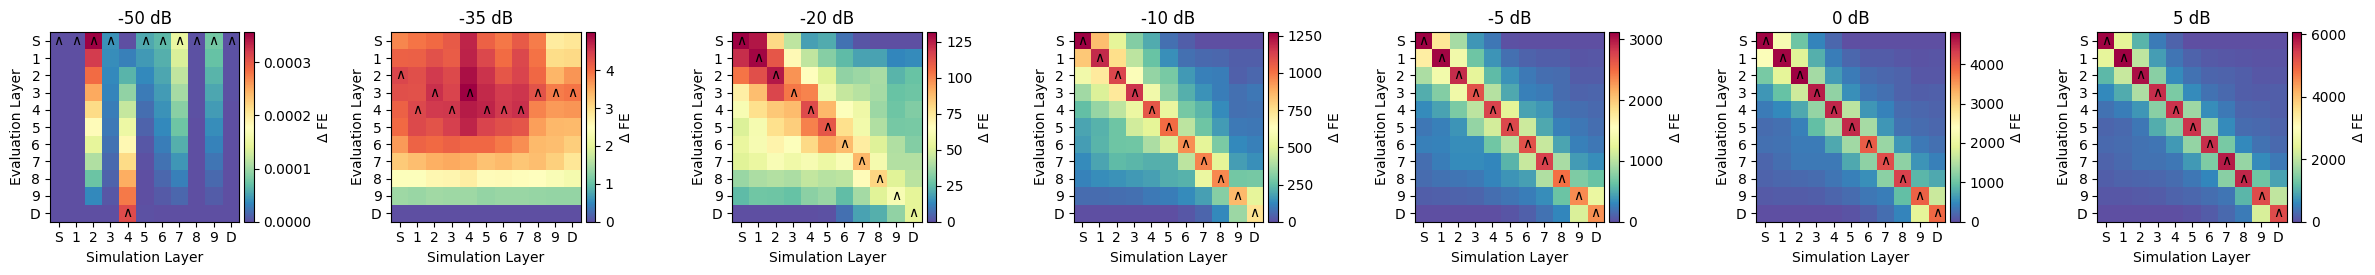

In [20]:
### SNR ###

output_dir = Path("/home/bonaiuto/laminar_baby/figures/")
f, ax = plt.subplots(1, am_wins, figsize=(24,3))
for snr_ix, snr in enumerate(snr_levels):
    ax[snr_ix].set_title(f"{snr} dB")
    m_mx = np.median(matrices_all[snr], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, annot)
plt.tight_layout()
f.savefig(output_dir.joinpath(f"median_snr.pdf"))
# plt.close()

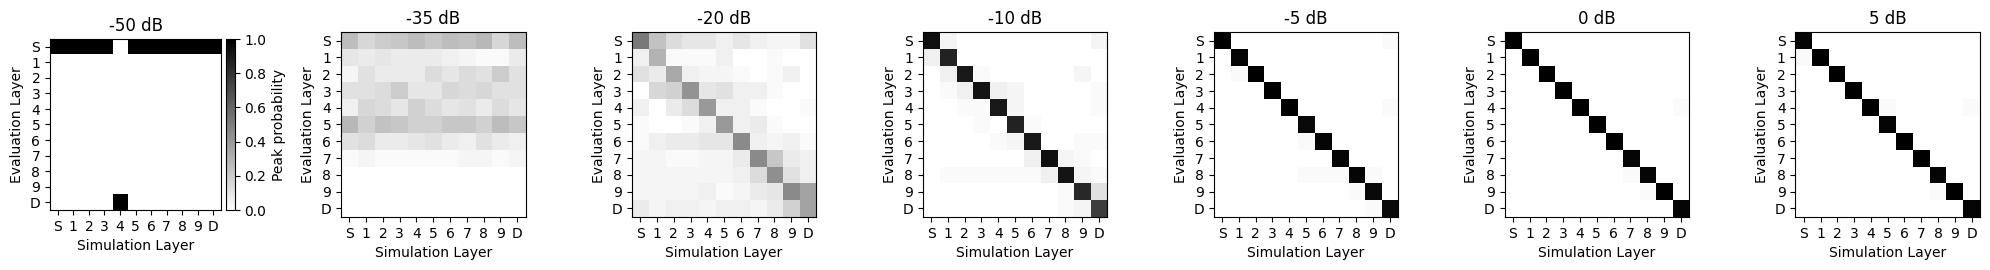

In [21]:
### SNR ###
output_dir = Path("/home/bonaiuto/laminar_baby/figures/")
divnorm = Normalize(vmin=0, vmax=1)
f, ax = plt.subplots(1, am_wins, figsize=(20,3))
for snr_ix, snr in enumerate(snr_levels):
    ax[snr_ix].set_title(f"{snr} dB")
    m_mx = np.mean(annots_bin[snr], axis=0)
    if snr_ix == 0:
        iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
    else:
        iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cmap="binary", norm=divnorm)
plt.tight_layout()
f.savefig(output_dir.joinpath(f"peak_location_probability.pdf"))
# plt.close()

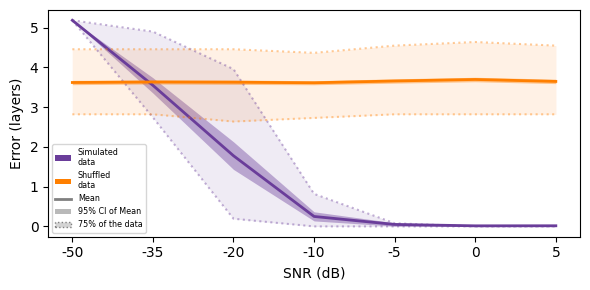

In [28]:
legend_handles = [
    Patch(facecolor="#6a3d9a", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="#ff7f00", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(6,3))
snr_range = np.arange(len(snr_levels))


res = []
shuf_res = []
for snr_ix, snr in enumerate(snr_levels):
    data = layers - np.array(peaks_all[snr])
    data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i, ab=True) for i in matrices_all[snr]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 12.5), 
        np.percentile(bs_mn, 87.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

res = np.array(res)
shuf_res = np.array(shuf_res)

clrs = ["#6a3d9a", "#ff7f00"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([res, shuf_res]):
    ax.plot(snr_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(snr_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.1)
    
    ax.plot(snr_range, r[:,3], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    ax.plot(snr_range, r[:,4], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(np.arange(len(snr_levels)))
ax.set_xticklabels([f"{i}" for i in snr_levels])
ax.set_ylabel("Error (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="xx-small")
plt.tight_layout()
f.savefig(output_dir.joinpath(f"error_abs_snr.pdf"))

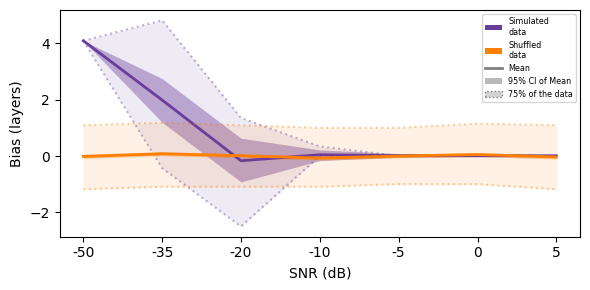

In [29]:
legend_handles = [
    Patch(facecolor="#6a3d9a", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="#ff7f00", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(6,3))
snr_range = np.arange(len(snr_levels))


res = []
shuf_res = []
for snr_ix, snr in enumerate(snr_levels):
    data = layers - np.array(peaks_all[snr])
#     data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i, ab=False) for i in matrices_all[snr]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 2.5), 
        np.percentile(bs_mn, 97.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

res = np.array(res)
shuf_res = np.array(shuf_res)

clrs = ["#6a3d9a", "#ff7f00"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([res, shuf_res]):
    ax.plot(snr_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(snr_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.1)
    
    ax.plot(snr_range, r[:,3], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    ax.plot(snr_range, r[:,4], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(np.arange(len(snr_levels)))
ax.set_xticklabels([f"{i}" for i in snr_levels])
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="xx-small")
plt.tight_layout()
f.savefig(output_dir.joinpath(f"error_snr.pdf"))

In [30]:
### COREG ERROR ###
output_dir = Path("/home/bonaiuto/laminar_baby/figures/")

err_vertices = np.unique([eval(f.stem.split("_")[1]) for f in coreg_files])
err_am_wins = len(err_levels)
err_matrices_all = {i: [] for i in err_levels}
err_peaks_all = {i: [] for i in err_levels}
err_annots_bin = {i: [] for i in err_levels}
err_shuffled_matrices_all = {i: [] for i in err_levels}
err_shuffled_peaks_all = {i: [] for i in err_levels}

for vx in err_vertices:
    vx_files = [i for i in coreg_files if str(vx) in i.stem]
    
    mx_all = []
    for err_ix, err in enumerate(err_levels):
        file_in = [i for i in vx_files if str(err) == i.stem.split("_")[-1]][0]
        with open(file_in, "rb") as file:
            output = pickle.load(file)
        mx_all.append(norm_res(output["all_layerF"]))
    mx_max = np.array(mx_all).max()
    f, ax = plt.subplots(1, err_am_wins, figsize=(24,3))
    score_norm = Normalize(vmin=0.0, vmax=mx_max)
    for err_ix, err in enumerate(err_levels):
        ax[err_ix].set_title(f"Coreg error: {err}")
        peaks, annot, annot_bin = find_peaks(mx_all[err_ix], marker=r"$\wedge$")
        iw = plot_mx(
            mx_all[err_ix], LAB, ax=ax[err_ix], labels=True, cbar=True
        )
        annotate_mx(iw, annot)
        err_matrices_all[err].append(mx_all[err_ix])
        err_peaks_all[err].append(peaks)
        err_annots_bin[err].append(annot_bin)
    
    plt.tight_layout()
    #f.savefig(output_dir.joinpath(f"err_coreg_mx_{vx}.svg"))
    plt.close()

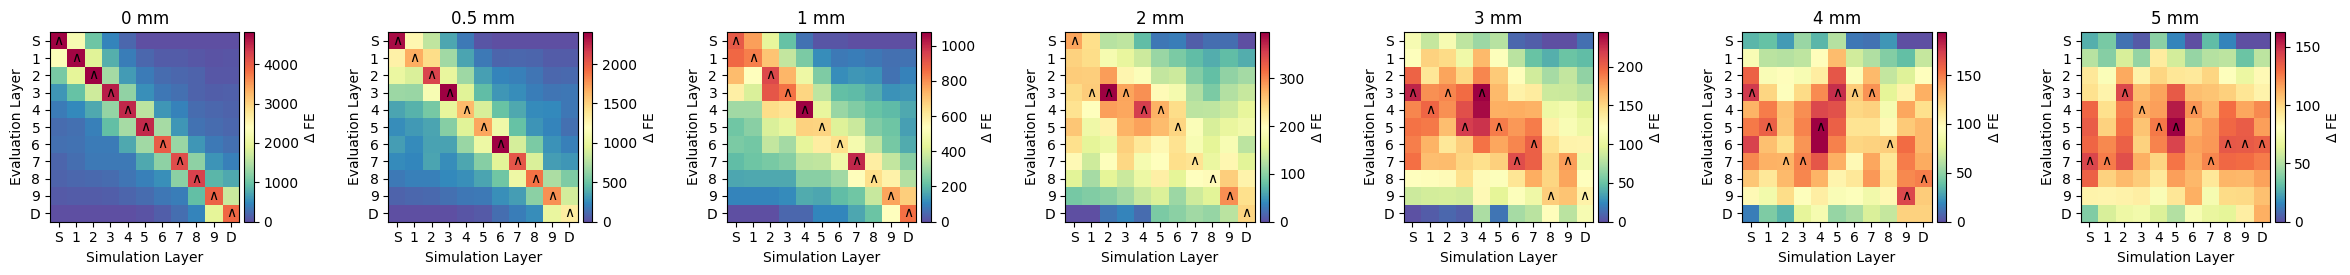

In [31]:
### COREG ###

output_dir = Path("/home/bonaiuto/laminar_baby/figures/")

f, ax = plt.subplots(1, err_am_wins, figsize=(24,3))
for err_ix, err in enumerate(err_levels):
    ax[err_ix].set_title(f"{err} mm")
    m_mx = np.median(err_matrices_all[err], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, LAB, ax=ax[err_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, annot)
plt.tight_layout()
f.savefig(output_dir.joinpath(f"median_err_coreg.pdf"))
# plt.close()

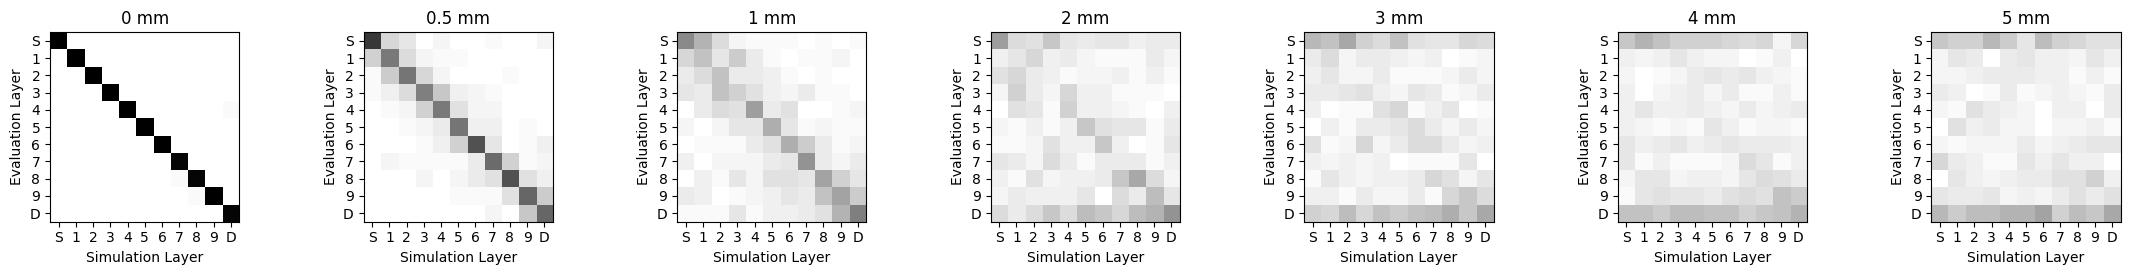

In [32]:
### COREG ###
output_dir = Path("/home/bonaiuto/laminar_baby/figures/")
divnorm = Normalize(vmin=0, vmax=1)
f, ax = plt.subplots(1, err_am_wins, figsize=(24,3))
for err_ix, err in enumerate(err_levels):
    ax[err_ix].set_title(f"{err} mm")
    m_mx = np.mean(err_annots_bin[err], axis=0)
    if snr_ix == 0:
        iw = plot_mx(m_mx, LAB, ax=ax[err_ix], labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
    else:
        iw = plot_mx(m_mx, LAB, ax=ax[err_ix], labels=True, cmap="binary", norm=divnorm)
plt.tight_layout()
f.savefig(output_dir.joinpath(f"peak_location_probability_err_coreg.pdf"))
# plt.close()

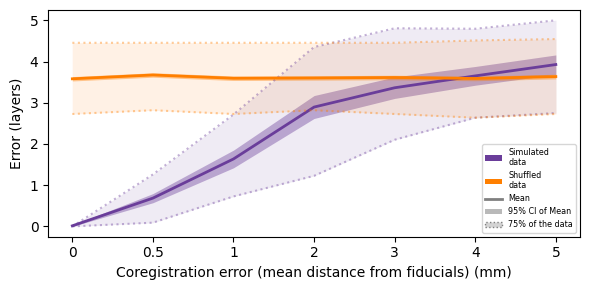

In [33]:
legend_handles = [
    Patch(facecolor="#6a3d9a", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="#ff7f00", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(6,3))
err_range = np.arange(len(err_levels))


res = []
shuf_res = []
for err_ix, err in enumerate(err_levels):
    data = layers - np.array(err_peaks_all[err])
    data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i, ab=True) for i in err_matrices_all[err]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 12.5), 
        np.percentile(bs_mn, 87.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

res = np.array(res)
shuf_res = np.array(shuf_res)

clrs = ["#6a3d9a", "#ff7f00"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([res, shuf_res]):
    ax.plot(err_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(err_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(err_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.1)
    
    ax.plot(err_range, r[:,3], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    ax.plot(err_range, r[:,4], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(np.arange(len(err_levels)))
ax.set_xticklabels([f"{i}" for i in err_levels])
ax.set_ylabel("Error (layers)")
ax.set_xlabel("Coregistration error (mean distance from fiducials) (mm)")
ax.legend(handles=legend_handles, fontsize="xx-small")
plt.tight_layout()
f.savefig(output_dir.joinpath(f"error_abs_err.pdf"))

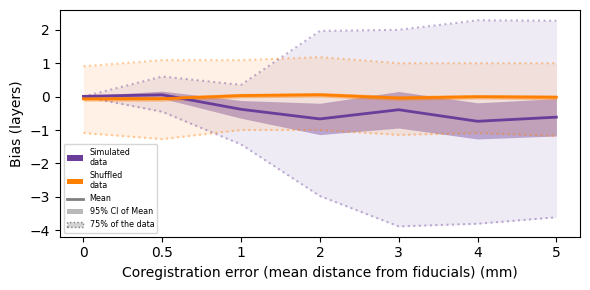

In [34]:
legend_handles = [
    Patch(facecolor="#6a3d9a", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="#ff7f00", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(6,3))
err_range = np.arange(len(err_levels))


res = []
shuf_res = []
for err_ix, err in enumerate(err_levels):
    data = layers - np.array(err_peaks_all[err])
#     data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i) for i in err_matrices_all[err]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 12.5), 
        np.percentile(bs_mn, 87.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

res = np.array(res)
shuf_res = np.array(shuf_res)

clrs = ["#6a3d9a", "#ff7f00"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([res, shuf_res]):
    ax.plot(err_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(err_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(err_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.1)
    
    ax.plot(err_range, r[:,3], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    ax.plot(err_range, r[:,4], ":", lw=1.5, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(np.arange(len(err_levels)))
ax.set_xticklabels([f"{i}" for i in err_levels])
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("Coregistration error (mean distance from fiducials) (mm)")
ax.legend(handles=legend_handles, fontsize="xx-small")
plt.tight_layout()
f.savefig(output_dir.joinpath(f"error_err.pdf"))